In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import linprog
import itertools
from typing import List, Tuple, Dict, Optional
from scipy.optimize import linear_sum_assignment


In [25]:
class MultiProductPricingEnvironment:
    def __init__(self, costs, price_grid, N, mean_vals, cov_matrix, seed=None):
        """
        costs: array of length N with cost for each product
        price_grid: list or array of possible prices (same for all products)
        mean_vals: array of length N, mean valuations for each product
        cov_matrix: N x N covariance matrix for joint valuations
        seed: optional random seed
        """
        self.costs = np.array(costs)
        self.price_grid = np.array(price_grid)
        self.N = N
        self.mean_vals = np.array(mean_vals)
        self.cov_matrix = np.array(cov_matrix)
        self.rng = np.random.default_rng(seed)

    def sample_valuations(self):
        """
        Sample a valuation vector from the joint normal distribution,
        clipped to [0, 1] as in the project spec.
        """
        while True:
            vals = self.rng.multivariate_normal(self.mean_vals, self.cov_matrix)
            if np.all((0 <= vals) & (vals <= 1)):
                return vals

    def round(self, offered_products, offered_prices):
        """
        offered_products: list of product indices offered this round
        offered_prices: list/array of prices for those products (same length as offered_products)

        Returns:
            purchases: binary array length N, 1 if bought, 0 otherwise
            revenue: total profit (sum over purchased products of price - cost)
        """
        valuations = self.sample_valuations()
        purchases = np.zeros(self.N, dtype=int)
        revenue = 0.0

        for prod, price in zip(offered_products, offered_prices):
            if valuations[prod] >= price:
                purchases[prod] = 1
                revenue += price - self.costs[prod]

        return purchases, revenue


In [ ]:
class CombinatorialPricingAgent:
    def __init__(self, n_products, n_slots, price_grid, T, budget=None):
        """
        n_products : total number of products
        n_slots    : how many products we can offer at once
        price_grid : array/list of possible prices (same for all products)
        T          : horizon
        budget     : optional budget for cost-sensitive pricing (if None, ignores budget)
        """
        self.n_products = n_products
        self.n_slots = n_slots
        self.price_grid = np.array(price_grid)
        self.T = T
        self.budget = budget
        self.rho = budget / T if budget else None
        
        # --- Combinatorial UCB for product selection ---
        self.W_avg = np.zeros((n_products, n_products))  # profit estimate matrix
        self.N_pulls = np.zeros((n_products, n_products))
        self.t = 0
        self.rows_t = None
        self.cols_t = None
        
        # --- Pricing UCB for each product ---
        self.K = len(price_grid)
        self.avg_f = np.zeros((n_products, self.K))  # expected revenue per price
        self.avg_c = np.zeros((n_products, self.K))  # expected cost per price
        self.N_pulls_price = np.zeros((n_products, self.K))
        self.last_prices = {}
    
    def select_products(self):
        """UCB-like combinatorial selection for which products to offer."""
        W = np.zeros_like(self.W_avg, dtype=float)
        large_value = (1 + np.sqrt(2 * np.log(self.T) / 1)) * 10
        W[self.N_pulls == 0] = large_value
        mask = self.N_pulls > 0
        W[mask] = self.W_avg[mask] + np.sqrt(2 * np.log(self.T) / self.N_pulls[mask])
        
        self.rows_t, self.cols_t = linear_sum_assignment(W, maximize=True)
        # Choose the first n_slots assignments
        chosen_pairs = list(zip(self.rows_t[:self.n_slots], self.cols_t[:self.n_slots]))
        chosen_products = [p for _, p in chosen_pairs]
        return chosen_products
    
    def select_prices(self, chosen_products):
        """UCB-like pricing decision for each chosen product."""
        chosen_prices = []
        for p in chosen_products:
            if np.any(self.N_pulls_price[p] == 0):
                # Try unexplored prices first
                price_idx = np.argmin(self.N_pulls_price[p])
            else:
                f_ucbs = self.avg_f[p] + np.sqrt(2 * np.log(self.T) / self.N_pulls_price[p])
                price_idx = np.argmax(f_ucbs)
            chosen_prices.append(self.price_grid[price_idx])
            self.last_prices[p] = price_idx
        return chosen_prices
    
    def pull_arm(self):
        """Returns: chosen_products, chosen_prices"""
        chosen_products = self.select_products()
        chosen_prices = self.select_prices(chosen_products)
        return chosen_products, chosen_prices
    
    def update(self, chosen_products, profits, costs):
        """
        chosen_products: list of product indices offered
        purchases: binary array (len = n_products) 1 if bought
        profits: array of profit for each offered product
        costs: array of cost for each offered product
        """
        # Update combinatorial estimates
        for i, prod in enumerate(chosen_products):
            self.N_pulls[prod, prod] += 1  # simplified: self-match
            self.W_avg[prod, prod] += (profits[i] - self.W_avg[prod, prod]) / self.N_pulls[prod, prod]
        
        # Update pricing estimates
        for i, prod in enumerate(chosen_products):
            price_idx = self.last_prices[prod]
            self.N_pulls_price[prod, price_idx] += 1
            self.avg_f[prod, price_idx] += (profits[i] - self.avg_f[prod, price_idx]) / self.N_pulls_price[prod, price_idx]
            self.avg_c[prod, price_idx] += (costs[i] - self.avg_c[prod, price_idx]) / self.N_pulls_price[prod, price_idx]
        
        self.t += 1

In [27]:
def clairvoyant_combined_regret(env, n_slots, rho, T, M=20000):
    """
    env             : MultiProductPricingEnvironment (with .sample_valuations(), .costs, .price_grid, .N)
    n_slots         : number of products that can be offered each round
    rho             : average budget per round (float)
    agent_rewards   : list/array of realized profits per round from the agent
    M               : Monte Carlo samples for expectation estimation
    
    Returns:
        best_subset     : list of chosen product indices (oracle)
        best_prices     : list of price distributions (gamma arrays) per product in subset
        oracle_mu       : oracle's expected reward per round
        cum_regret      : cumulative regret over the run
    """
    N = env.N
    price_grid = np.array(env.price_grid)
    costs = np.array(env.costs)
    K = len(price_grid)

    # --- Precompute true win probabilities & expected rewards for each (product, price) ---
    win_prob = np.zeros((N, K))
    reward_val = np.zeros((N, K))
    for _ in range(M):
        vals = env.sample_valuations()
        for i in range(N):
            for k, p in enumerate(price_grid):
                if vals[i] >= p:
                    win_prob[i, k] += 1
                    reward_val[i, k] += p - costs[i]
    win_prob /= M
    reward_val /= M

    # --- For each product, solve budget-constrained pricing LP ---
    best_price_reward = np.zeros(N)   # best achievable expected reward per product
    best_price_gamma  = [None] * N    # store the price distribution (gamma) for the oracle
    for i in range(N):
        c = -reward_val[i]  # maximize reward
        A_ub = [win_prob[i]]
        b_ub = [rho]
        A_eq = [np.ones(K)]
        b_eq = [1.0]
        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                      bounds=[(0, 1)] * K, method='highs')
        if res.success:
            best_price_reward[i] = -res.fun
            best_price_gamma[i] = res.x
        else:
            best_price_reward[i] = 0.0
            best_price_gamma[i] = np.ones(K) / K  # fallback uniform

    # --- Combinatorial matching to pick top n_slots products ---
    # Here we use a diagonal W for product-to-slot match (no worker/task asymmetry)
    W = np.tile(best_price_reward, (N, 1))  # shape N x N
    rows, cols = linear_sum_assignment(W, maximize=True)
    chosen_pairs = list(zip(rows[:n_slots], cols[:n_slots]))
    chosen_products = [p for _, p in chosen_pairs]
    oracle_mu = np.sum(best_price_reward[chosen_products])

    # --- Regret ---
    cum_regret = T * oracle_mu 

    # Extract price distributions for the chosen products
    chosen_gammas = [best_price_gamma[p] for p in chosen_products]

    return chosen_products, chosen_gammas, oracle_mu, cum_regret


In [30]:
T = 5000
B = 2000
rho = B / T
n_slots = 2          # products per round
n_products = 5       # total products

epsilon = T ** (-0.33)
K = int(1 / epsilon)
prices = np.linspace(0, 1, K)

costs = np.zeros(n_products)  # zero cost
n_epochs = 10

all_regrets = []
all_payments = []
all_pulls = []

for seed in range(n_epochs):
    np.random.seed(seed)

    # Create a random but fixed environment
    mean_vals = np.random.uniform(0.3, 0.7, size=n_products)
    cov_matrix = 0.02 * np.ones((n_products, n_products)) + 0.05 * np.eye(n_products)
    env = MultiProductPricingEnvironment(costs, prices, n_products, mean_vals, cov_matrix, seed=seed)

    # Clairvoyant computation for combined setting
    _ , _, _, oracle_reward = clairvoyant_combined_regret(env, n_slots, rho, T)

    # --- Initialize your combined agent ---
    agent = CombinatorialPricingAgent(n_products, n_slots, prices, T, B)  # You define this

    utilities = []
    my_payments = []
    total_wins = 0

    for t in range(T):
        # Agent chooses products & prices
        offered_products, offered_prices = agent.pull_arm()

        # Environment simulates purchases and profit
        purchases, profit = env.round(offered_products, offered_prices)

        # Here cost is number of purchases (budget constraint)
        c_t = purchases.sum()

        # Agent learns
        agent.update(purchases, profit, c_t)

        # Logging
        utilities.append(profit)
        my_payments.append(c_t)
        total_wins += c_t

    utilities = np.array(utilities)
    my_payments = np.array(my_payments)

    print(f"Epoch {seed+1} | Total Wins: {total_wins}")

    # Regret tracking
    all_regrets.append(np.cumsum(oracle_reward - utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

# Aggregate stats
avg_regret = np.mean(all_regrets, axis=0)
std_regret = np.std(all_regrets, axis=0)
avg_payments = np.mean(all_payments, axis=0)
std_payments = np.std(all_payments, axis=0)
avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)

print(f"Final Average Regret: {avg_regret[-1]:.3f}")

TypeError: CombinatorialPricingAgent.update() missing 1 required positional argument: 'costs'

Optimal action: products [0, 1, 2] at prices [np.float64(0.32105263157894737), np.float64(0.39473684210526316), np.float64(0.46842105263157896)]
Expected optimal revenue per round: 1.0134

Running epoch 1/10
  Round 200: Avg reward = 0.6249, Avg regret = 0.3885
  Round 400: Avg reward = 0.6524, Avg regret = 0.3610
  Round 600: Avg reward = 0.7063, Avg regret = 0.3071
  Round 800: Avg reward = 0.6758, Avg regret = 0.3376
  Round 1000: Avg reward = 0.7150, Avg regret = 0.2984
  Epoch total reward: 674.86

Running epoch 2/10
  Round 200: Avg reward = 0.5725, Avg regret = 0.4409
  Round 400: Avg reward = 0.6187, Avg regret = 0.3947
  Round 600: Avg reward = 0.6739, Avg regret = 0.3395
  Round 800: Avg reward = 0.7023, Avg regret = 0.3111
  Round 1000: Avg reward = 0.7114, Avg regret = 0.3020
  Epoch total reward: 655.77

Running epoch 3/10
  Round 200: Avg reward = 0.5704, Avg regret = 0.4429
  Round 400: Avg reward = 0.6524, Avg regret = 0.3610
  Round 600: Avg reward = 0.6797, Avg regret

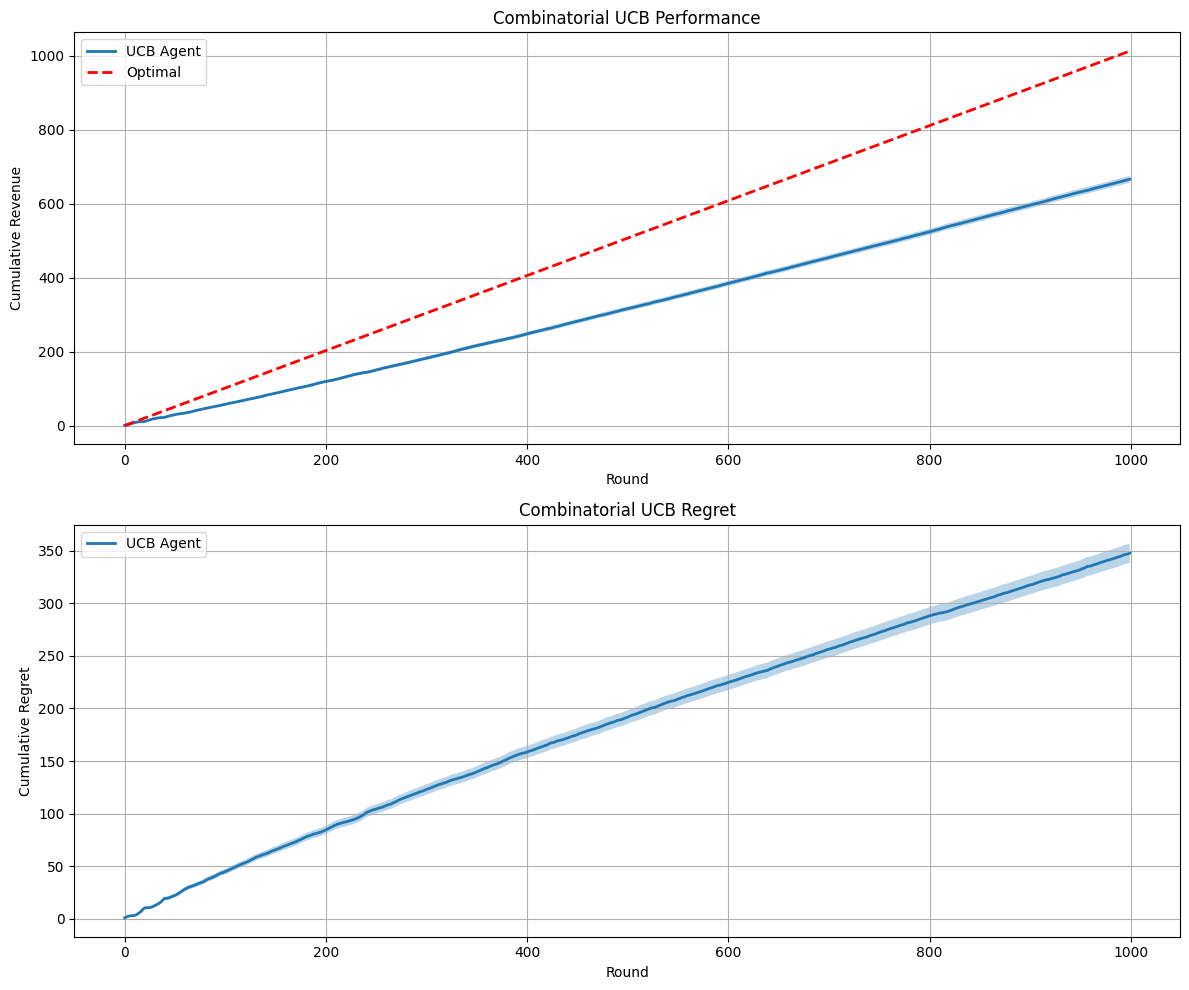


=== Final Results (averaged over 10 epochs) ===
Total revenue: 665.75 ± 9.17
Optimal total revenue: 1013.39
Final cumulative regret: 347.63 ± 9.17
Average regret per round: 0.3476

=== Agent's Learning Analysis ===
Total pulls per product-price pair:
Product 0:
  Price 0.10: 44 pulls, avg reward 0.1000
  Price 0.14: 50 pulls, avg reward 0.1368
  Price 0.17: 57 pulls, avg reward 0.1706
  Price 0.21: 66 pulls, avg reward 0.2041
  Price 0.25: 71 pulls, avg reward 0.2230
  Price 0.28: 85 pulls, avg reward 0.2608
  Price 0.32: 80 pulls, avg reward 0.2488
  Price 0.36: 88 pulls, avg reward 0.2684
  Price 0.39: 60 pulls, avg reward 0.1842
  Price 0.43: 55 pulls, avg reward 0.1569
  Price 0.47: 44 pulls, avg reward 0.0958
  Price 0.51: 40 pulls, avg reward 0.0758
  Price 0.54: 35 pulls, avg reward 0.0310
  Price 0.58: 33 pulls, avg reward 0.0175
  Price 0.62: 32 pulls, avg reward 0.0000
  Price 0.65: 32 pulls, avg reward 0.0000
  Price 0.69: 32 pulls, avg reward 0.0000
  Price 0.73: 32 pulls,

In [ ]:

# If avg_pulls is shape (n_epochs, n_products, K) → sum over products
if avg_pulls.ndim == 3:
    avg_pulls_prices = avg_pulls.sum(axis=1)  # shape: (n_epochs, K)
    avg_pulls_mean = avg_pulls_prices.mean(axis=0)
    avg_pulls_std = avg_pulls_prices.std(axis=0)
else:
    avg_pulls_mean = avg_pulls.mean(axis=0)
    avg_pulls_std = avg_pulls.std(axis=0)

# --- Plot chosen bids/prices ---
plt.figure()
plt.plot(prices, avg_pulls_mean)
plt.fill_between(prices, avg_pulls_mean - avg_pulls_std, avg_pulls_mean + avg_pulls_std, alpha=0.3)
plt.xlabel('$b$')
plt.ylabel('$n(b)$')
plt.title('Chosen Bids (Summed over Products)')
plt.show()

# --- Plot cumulative payments ---
plt.figure()
plt.plot(np.arange(T), avg_payments, label='Cumulative Payments')
plt.fill_between(np.arange(T), avg_payments - std_payments, avg_payments + std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Combined UCB')
plt.show()

# --- Plot cumulative regret ---
plt.figure()
plt.plot(np.arange(T), avg_regret, label='Cumulative Regret')
plt.fill_between(np.arange(T), avg_regret - std_regret, avg_regret + std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Combined UCB')
plt.show()

# --- Print summary stats ---
print(f"Final Average Regret: {avg_regret[-1]:.3f} ± {std_regret[-1]:.3f}")
print(f"Final Average Payments: {avg_payments[-1]:.3f} ± {std_payments[-1]:.3f}")
print("Average pulls per price (summed over products):")
print(avg_pulls_mean)